# Exploring photon heights with ICESat-2 (ATL03)

Information obtained primarily from the ATL03 Algorithm Theoretical Basis Document (ATBD, Neumann et al., 2019) and the NSIDC product description page: https://nsidc.org/data/atl03.   

* Notebook author: Alek Petty, relying extensively on above product manuals.    
* Description: Notebook describing the ICESat-2 ATL03 product.   
* Input requirements: Demo ATL03 data file   
* Date: June 2019
* More info: See the ATL03 Algorithm Theoretical Basis Document (ATBD): https://icesat-2.gsfc.nasa.gov/sites/default/files/page_files/ICESat2_ATL03_ATBD_r001.pdf and the known issues document: https://nsidc.org/sites/nsidc.org/files/technical-references/ATL03_Known_Issues_May2019.pdf


## To do

* How to do cloud (and negative value) filtering!? Think this is in the generation of ATL07 though, but I at least need some comments about that.

## Notebook objectives
* General understanding of what's included in a typical ATL03 file.
* Plotting and basic analysis of ATL03 data.


# Notebook instructions
1. Follow along with the notebook tutorial. 
2. Play around changing options and re-running the relevant notebook cells. 

Here I use the hdf5 file from: https://nsidc.org/data/atl03
For the demo below I'm using the file: X
If using this using the ICESAT-2 Pangeo instance, you can download the file using...





In [27]:
#Magic function to enable interactive plotting in Jupyter notebook
#Allows you to zoom/pan within plots after generating
#Normally, this would be %matplotlib notebook, but since we're using Juptyerlab, we need a different widget
#%matplotlib notebook
%matplotlib inline

In [28]:
#Import necesary modules
#Use shorter names (np, pd, plt) instead of full (numpy, pandas, matplotlib.pylot) for convenience
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import convert_GPS_time as cGPS
import seaborn as sns
import pandas as pd
import h5py  
# Use seasborn for nicer looking inline plots
sns.set(context='notebook', style='darkgrid')
#st = axes_style("whitegrid")

In [29]:
# add an option if you want to spit out data as an array or a pandas dataframe.

def getATL03data(fileT, numpy=0, beam='gt1l', maxElev=1e6):
    # Add in a proper description of the function here
    
    # Open the file
    ATL03 = h5py.File(fileT, 'r')
    
    lons=ATL03[beam+'/heights/lon_ph'][:]
    lats=ATL03[beam+'/heights/lat_ph'][:]
    
    # Along track distance from equator i think.
    along_track_distance=ATL03[beam+'/heights/dist_ph_along'][:] 
    
    #  Nathan says it's the number of seconds since the GPS epoch on midnight Jan. 6, 1980 
    delta_time=ATL03[beam+'/heights/delta_time'][:] 
    
    # #Add this value to delta time parameters to compute full gps_seconds
    atlas_epoch=ATL03['/ancillary_data/atlas_sdp_gps_epoch'][:] 
    
    # Conversion of delta_time to a calendar date
    temp = cGPS.convert_GPS_time(atlas_epoch[0] + delta_time, OFFSET=0.0)
    
    # Express delta_time relative to start time of granule
    delta_time_granule=delta_time-delta_time[0]

    year = temp['year'][:].astype('int')
    month = temp['month'][:].astype('int')
    day = temp['day'][:].astype('int')
    hour = temp['hour'][:].astype('int')
    minute = temp['minute'][:].astype('int')
    second = temp['second'][:].astype('int')

    # Primary variables of interest
    
    # Photon height
    heights=ATL03[beam+'/heights/h_ph'][:]
    print(heights.shape)
    # Flag for signal confidence
    # column index:  0=Land; 1=Ocean; 2=SeaIce; 3=LandIce; 4=InlandWater
    # values:
        #-- -1: Events not associated with a specific surface type
        #--  0: noise
        #--  1: buffer but algorithm classifies as background
        #--  2: low
        #--  3: medium
        #--  4: high
    signal_confidence=ATL03[beam+'/heights/signal_conf_ph'][:,2] 
    print(signal_confidence.shape)
    
    ATL03.close()
    
    if (numpy==1):
        # list the variables you want to output here..
        return along_track_dist, elev
    
    else:
        dF = pd.DataFrame({'heights':heights, 'lons':lons, 'lats':lats, 'signal_confidence':signal_confidence, 
                       'delta_time':delta_time_granule,'along_track_distance':along_track_distance, 'year':year, 'month':month, 'day':day, 'hour':hour, 'second':second})
        
        # Filter out high elevation values 
        #dF = dF[(dF['signal_confidence']>2)]
        # Reset row indexing
        #dF=dF.reset_index(drop=True)
        return dF


In [30]:
file_path = './'
ATL03_filename = 'ATL03_20181115022655_07250104_001_01.h5'
ATL03_file_path = file_path + ATL03_filename
beamStr='gt1r'

dF03=getATL03data(ATL03_file_path, beam=beamStr)


(19105034,)
(19105034,)


In [31]:
dF03.tail(5)

,along_track_distance,day,delta_time,heights,hour,lats,lons,month,second,signal_confidence,year
19105029,17.451059,15,309.160807,938.635193,2,79.994335,4.479386,11,4,4,2018
19105030,18.308546,15,309.160907,956.879639,2,79.994328,4.479368,11,4,4,2018
19105031,19.037317,15,309.161007,960.410461,2,79.994322,4.479358,11,4,4,2018
19105032,19.784542,15,309.161107,966.907166,2,79.994316,4.479347,11,4,4,2018
19105033,19.762459,15,309.161107,963.295776,2,79.994316,4.479349,11,4,4,2018


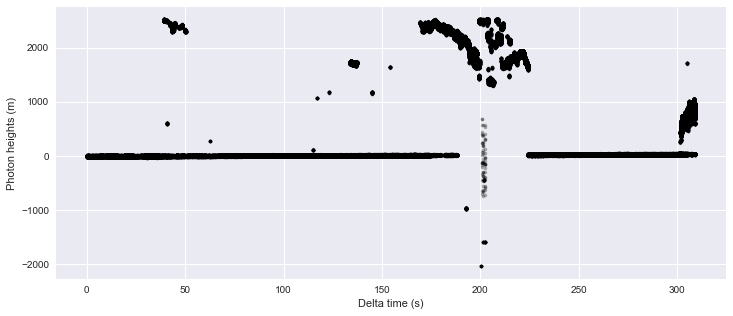

In [32]:
plt.figure(figsize=(12, 5))
plt.plot(dF03['delta_time'],dF03['heights'], color='k', marker='.', linestyle='None', alpha=0.3)
plt.xlabel('Delta time (s)')
plt.ylabel('Photon heights (m)')
plt.show()


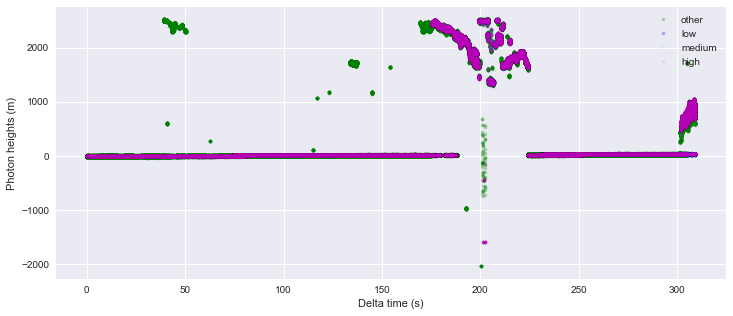

In [33]:
#dF = dF03[(dF['signal_confidence']>2)]
#np.size(np.where(dF03['signal_confidence']==3))
plt.figure(figsize=(12, 5))
plt.plot(dF03[(dF03['signal_confidence']<2)]['delta_time'],dF03[(dF03['signal_confidence']<2)]['heights'], label='other', color='g', marker='.', linestyle='None', alpha=0.3)
plt.plot(dF03[(dF03['signal_confidence']==2)]['delta_time'],dF03[(dF03['signal_confidence']==2)]['heights'], label='low', color='b', marker='.', linestyle='None', alpha=0.3)
plt.plot(dF03[(dF03['signal_confidence']==3)]['delta_time'],dF03[(dF03['signal_confidence']==3)]['heights'], label='medium', color='c', marker='.', linestyle='None', alpha=0.1)
plt.plot(dF03[(dF03['signal_confidence']==4)]['delta_time'],dF03[(dF03['signal_confidence']==4)]['heights'], label='high', color='m', marker='.', linestyle='None', alpha=0.1)
plt.legend(loc=1)
plt.xlabel('Delta time (s)')
plt.ylabel('Photon heights (m)')
plt.show()

# Another (more elegant but less flexible) of doing a plot like this is using seaborn...
#plt.figure(figsize=(12, 5))
#sns.pairplot(x_vars=["delta_time"], y_vars=["heights"], data=dF03, 
#hue="signal_confidence", size=5)
#plt.gca().set_ylim((0, 50000))

In [34]:
# How to do cloud (and negative value) filtering!? Think this is in the generation of ATL07?